In [2]:
import sys
print('python', sys.version)

import numpy as np
print('numpy', np.__version__)

import pandas as pd
print('pandas', pd.__version__)

import matplotlib as mpl
print('matplotlib', mpl.__version__)

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci
import glob
import networkx as nx
import Bio.KEGG.KGML.KGML_parser as keg

from sklearn.metrics import roc_curve, auc

import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import cmapPy.pandasGEXpress.parse as cp
import cmapPy.pandasGEXpress.write_gctx as cw

import matplotlib.patches as mpatches

python 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:27:36) [GCC 11.2.0]
numpy 1.26.4
pandas 2.2.3
matplotlib 3.10.0


# entrez to sym gene mapping

In [3]:
# mapping human gene symbol to entrez
dat=pd.read_table('data/Sym2Entrez.txt',sep='\t')
dat.columns=['sym','entrez']
dat=dat.loc[dat['entrez'].notnull()]
dat=dat.loc[dat['sym'].notnull()]
dat['entrez']=dat['entrez'].astype(int).astype(str)
s2e_dic=dat.set_index('sym')['entrez']
e2s_dic=dat.set_index('entrez')['sym']

# NCES computed across all combinations (Table S3)

In [494]:
new_cols=['BES',
     'STRING|w/o Cor.|0.2',
     'STRING|w/o Cor.|0.4',
     'STRING|w/o Cor.|0.6',
     'STRING|w/o Cor.|0.8',
     'STRING|Comp Cor.|0.2',
     'STRING|Comp Cor.|0.4',
     'STRING|Comp Cor.|0.6',
     'STRING|Comp Cor.|0.8',
     'STRING|CRISPR Cor.|0.2',
     'STRING|CRISPR Cor.|0.4',
     'STRING|CRISPR Cor.|0.6',
     'STRING|CRISPR Cor.|0.8',
     'OmniPath|w/o Cor.|0.2',
     'OmniPath|w/o Cor.|0.4',
     'OmniPath|w/o Cor.|0.6',
     'OmniPath|w/o Cor.|0.8',
     'OmniPath|Comp Cor.|0.2',
     'OmniPath|Comp Cor.|0.4',
     'OmniPath|Comp Cor.|0.6',
     'OmniPath|Comp Cor.|0.8',
     'OmniPath|CRISPR Cor.|0.2',
     'OmniPath|CRISPR Cor.|0.4',
     'OmniPath|CRISPR Cor.|0.6',
     'OmniPath|CRISPR Cor.|0.8']

with open("./results/two_ppi_agg_p_ess_score.pickle", 'rb') as file:
    ess_score_df=pickle.load(file)

NCES_all_cell_df=pd.DataFrame()
for cell in ess_score_df.keys():
    df=ess_score_df[cell]

    regex = rf"^(string_ppi|omnipath_all_ppi)\|max\|(crispr|chemical)\|(exp_abs\(cor\)|no_cor)\|(0\.2|0\.4|0\.6|0\.8)$"
    cols_ori = df.filter(regex=regex).columns
    cols_sel=['BES']+[col for col in cols_ori if 'crispr|no_cor' not in col]
    df_sel=df[cols_sel]
    df_sel.columns=[col.replace('max|','')
                    .replace('string_ppi', 'STRING').replace('omnipath_all_ppi', 'OmniPath')
                    .replace('chemical|no_cor', 'w/o Cor.')
                   .replace('crispr', 'CRISPR Cor.').replace('chemical', 'Comp Cor.')
                    .replace('exp_abs(cor)|','') for col in df_sel.columns]


    df_sel=df_sel[new_cols]
    df_sel.columns = pd.MultiIndex.from_product([[cell], df_sel.columns])
    df_sel=df_sel.map(lambda x: f'{x:.5f}')
    NCES_all_cell_df=pd.concat([NCES_all_cell_df, df_sel], axis=1)
NCES_all_cell_df=NCES_all_cell_df.rename(index=e2s_dic)
NCES_all_cell_df
NCES_all_cell_df.to_csv('results/NCES_all_cell.csv', sep=',')

A549                                                              \
              BES STRING|w/o Cor.|0.2 STRING|w/o Cor.|0.4 STRING|w/o Cor.|0.6   
A1BG      0.10589             0.10589             0.10589             0.10589   
A1CF      0.01148             0.06152             0.11156             0.16160   
A2M      -0.00497            -0.00497            -0.00497            -0.00497   
A2ML1    -0.01789             0.06406             0.14601             0.22796   
A3GALT2   0.03440             0.09846             0.16251             0.22656   
...           ...                 ...                 ...                 ...   
ZYG11A   -0.03440             0.47171             0.97781             1.48392   
ZYG11B    0.21105             0.46301             0.71498             0.96694   
ZYX      -0.13223             0.15834             0.44891             0.73949   
ZZEF1     0.24906             0.24906             0.24906             0.24906   
ZZZ3      0.44042             0.44042             0.44042             0.44042   

                                                                       \
        STRING|w/o Cor.|0.8 STRING|Comp Cor.|0.2 STRING|Comp Cor.|0.4   
A1BG                0.10589              0.10589              0.10589   
A1CF                0.21165              0.07750              0.14351   
A2M                -0.00497             -0.00497             -0.00497   
A2ML1               0.30991              0.06406              0.14601   
A3GALT2             0.29062              0.09846              0.16251   
...                     ...                  ...                  ...   
ZYG11A              1.99002              0.47171              0.97781   
ZYG11B              1.21891              0.46301              0.71498   
ZYX                 1.03006              0.15834              0.44891   
ZZEF1               0.24906              0.24906              0.24906   
ZZZ3                0.44042              0.44042              0.44042   

                                                                          ...  \
        STRING|Comp Cor.|0.6 STRING|Comp Cor.|0.8 STRING|CRISPR Cor.|0.2  ...   
A1BG                 0.10589              0.10589                0.10589  ...   
A1CF                 0.20953              0.27555                0.07023  ...   
A2M                 -0.00497             -0.00497               -0.00497  ...   
A2ML1                0.22796              0.30991                0.06406  ...   
A3GALT2              0.22656              0.29062                0.09846  ...   
...                      ...                  ...                    ...  ...   
ZYG11A               1.48392              1.99002                0.47171  ...   
ZYG11B               0.96694              1.21891                0.46301  ...   
ZYX                  0.73949              1.03006                0.15834  ...   
ZZEF1                0.24906              0.24906                0.24906  ...   
ZZZ3                 0.44042              0.44042                0.44042  ...   

                         MCF7                                               \
        OmniPath|w/o Cor.|0.6 OmniPath|w/o Cor.|0.8 OmniPath|Comp Cor.|0.2   
A1BG                  0.59662               0.79528                0.19931   
A1CF                 -0.00375              -0.00151               -0.00815   
A2M                   1.30667               1.77571                0.44638   
A2ML1                 0.95858               1.29308                0.28957   
A3GALT2               0.07355               0.07355                0.07355   
...                       ...                   ...                    ...   
ZYG11A               -0.07295              -0.11302                0.00718   
ZYG11B                0.06722               0.03493                0.13181   
ZYX                   1.54941               2.12209                0.64616   
ZZEF1                 0.86812               1.12650                0.37964   
ZZZ3               

# Best performed NCES (Table S5)

In [8]:
new_cols=['OmniPath|CRISPR Cor.|0.8']

with open("./results/two_ppi_agg_p_ess_score.pickle", 'rb') as file:
    ess_score_df=pickle.load(file)

NCES_all_cell_df=pd.DataFrame()
for cell in ess_score_df.keys():
    df=ess_score_df[cell]

    regex = rf"^(string_ppi|omnipath_all_ppi)\|max\|(crispr|chemical)\|(exp_abs\(cor\)|no_cor)\|(0\.2|0\.4|0\.6|0\.8)$"
    cols_ori = df.filter(regex=regex).columns
    cols_sel=['BES']+[col for col in cols_ori if 'crispr|no_cor' not in col]
    df_sel=df[cols_sel]
    df_sel.columns=[col.replace('max|','')
                    .replace('string_ppi', 'STRING').replace('omnipath_all_ppi', 'OmniPath')
                    .replace('chemical|no_cor', 'w/o Cor.')
                   .replace('crispr', 'CRISPR Cor.').replace('chemical', 'Comp Cor.')
                    .replace('exp_abs(cor)|','') for col in df_sel.columns]


    df_sel=df_sel[new_cols]
    df_sel=df_sel.map(lambda x: f'{x:.5f}')
    df_sel.columns=[cell]
    NCES_all_cell_df=pd.concat([NCES_all_cell_df, df_sel], axis=1)
NCES_all_cell_df=NCES_all_cell_df.rename(index=e2s_dic)
NCES_all_cell_df
NCES_all_cell_df.to_csv('results/Best_NCES_all_cell.csv', sep=',')

,A549,A375,BICR6,HT29,PC3,U251MG,MCF7
A1BG,0.79497,0.00786,0.67003,0.28397,0.44367,1.06930,0.87219
A1CF,0.40189,0.05885,0.17755,0.38184,0.21970,0.14635,-0.00151
A2M,0.89461,0.27938,0.70232,0.55599,0.72722,0.96656,1.77571
A2ML1,1.27105,1.29932,1.05245,1.16825,1.37814,1.50719,1.29308
A3GALT2,0.03440,0.08701,0.05991,-0.02839,0.12219,0.12066,0.07355
...,...,...,...,...,...,...,...
ZYG11A,-0.12062,-0.20153,-0.19980,-0.09771,-0.22783,-0.12536,-0.11302
ZYG11B,0.02484,0.01683,0.13162,0.08426,0.22624,0.05944,0.03493
ZYX,2.04982,1.81948,2.77080,2.25648,2.36317,2.97712,2.12209
ZZEF1,1.07113,0.78955,0.94760,0.87714,1.36158,1.13854,1.12650


# NCES computed in A375 (Figure 3)

<Axes: >

<Axes: >

Text(0.5, 0.98, 'A375')

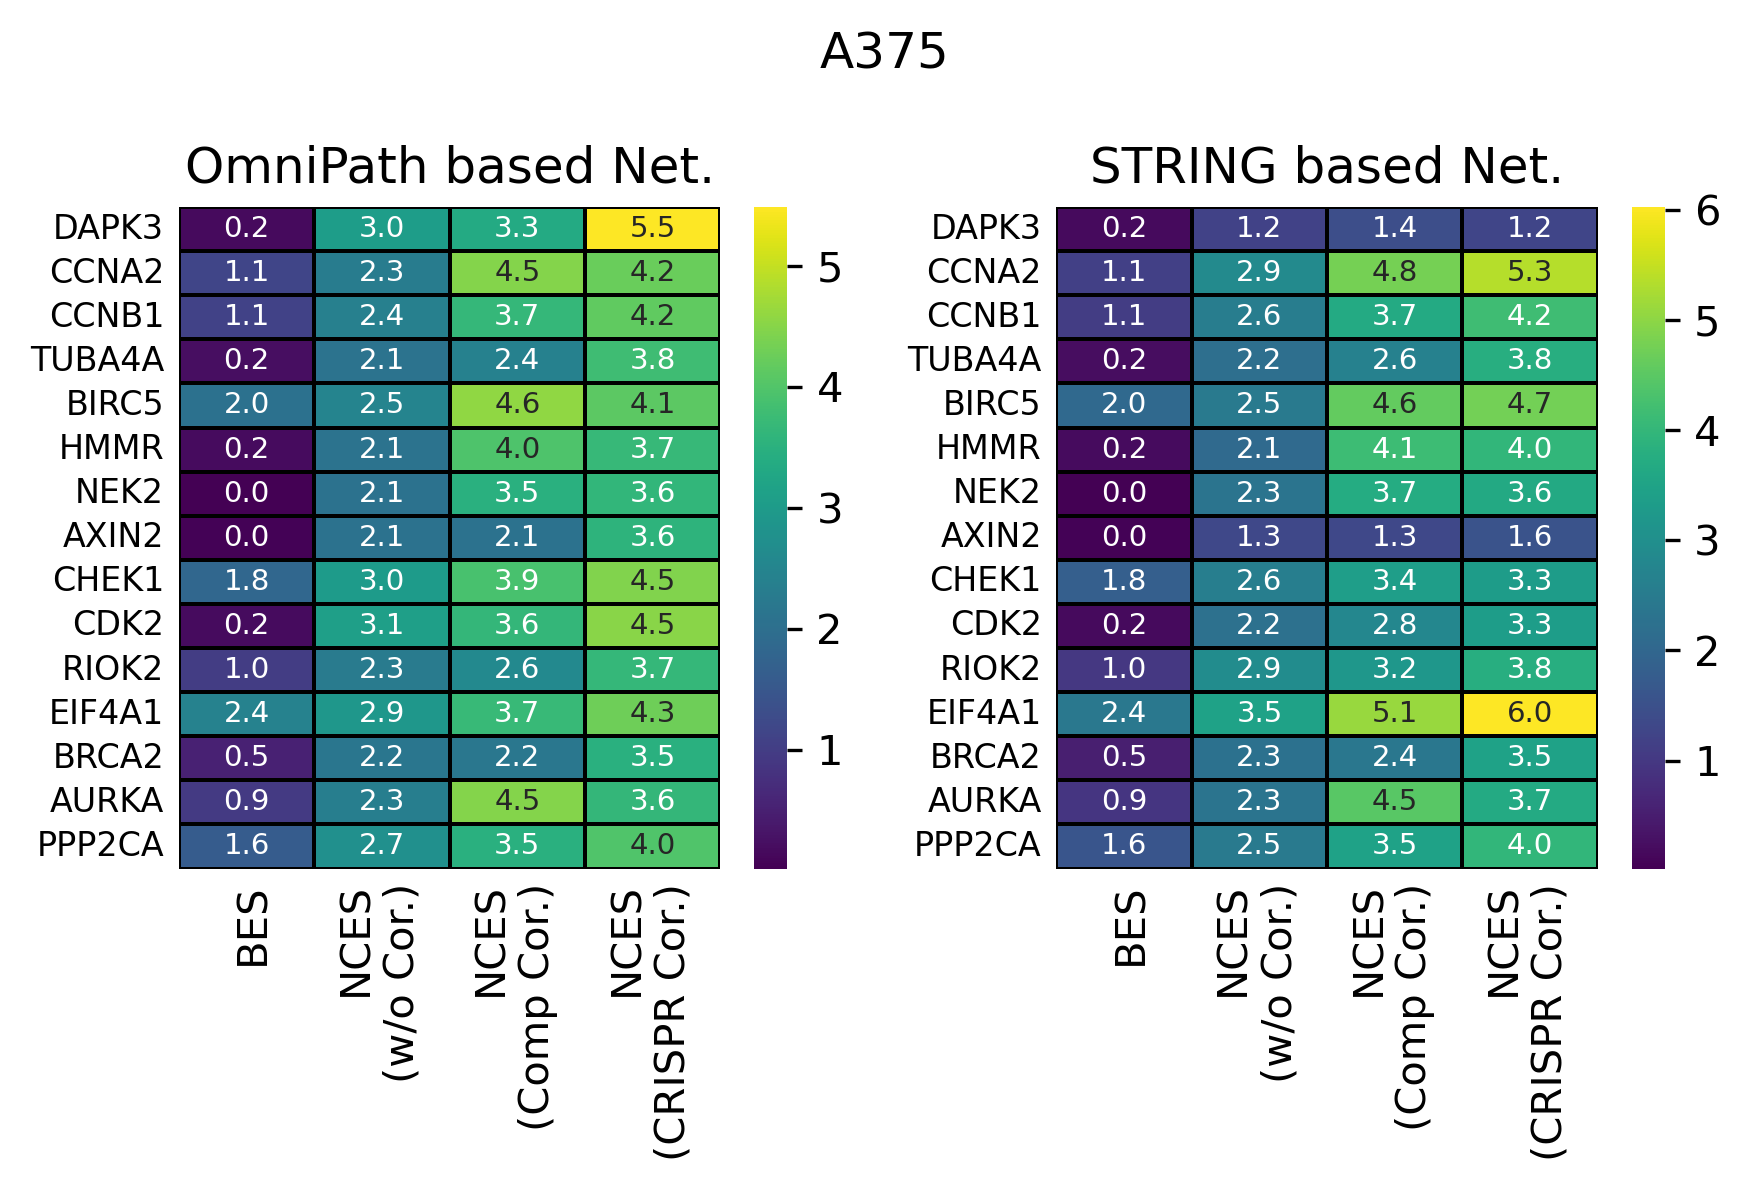

In [14]:
fig=plt.figure(figsize=(6,4), dpi=300)
axs=fig.subplots(1,2).flatten()

gs_name={'TTD':'TTD','drugbank':'DrugBank'}

ppi_name={'omnipath_all_ppi':'OmniPath based Net.',
          'string_ppi':'STRING based Net.'}


colors = ['gray', 'orange', 'deeppink', 'darkblue']

with open("./results/two_ppi_agg_p_ess_score.pickle", 'rb') as file:
    ess_score_df=pickle.load(file)
    
cell='A375'
cell_df=ess_score_df[cell]

cell='A375'
cell_df=ess_score_df[cell]

score_name_dic={}

def get_model_name(score):
    if 'chemical|no_cor' in score:
        return 'NCES\n(w/o Cor.)'
    if 'crispr|exp_abs(cor)' in score:
        return 'NCES\n(CRISPR Cor.)'
    if 'chemical|exp_abs(cor)' in score:
        return 'NCES\n(Comp Cor.)'
    if 'BES' in score:
        return 'BES'

ppi_name={'omnipath_all_ppi':'OmniPath based Net.',
          'string_ppi':'STRING based Net.'}

ii=0
for ppi in ['omnipath_all_ppi','string_ppi']:
    ax=axs[ii]
    regex = rf"^{ppi}\|max\|(crispr|chemical)\|(exp_abs\(cor\)|no_cor)\|0\.8$"
    cols_ori = cell_df.filter(regex=regex).columns
    score_cols=['BES']+[col for col in cols_ori if 'crispr|no_cor' not in col]
    ppi_df=cell_df[score_cols]
    ppi_df.columns=[get_model_name(col) for col in ppi_df.columns]
    ppi_df=ppi_df[['BES','NCES\n(w/o Cor.)','NCES\n(Comp Cor.)','NCES\n(CRISPR Cor.)']]
    ppi_df['NCES_diff']=abs(ppi_df['NCES\n(w/o Cor.)']-ppi_df['NCES\n(CRISPR Cor.)'])
    ppi_df = ppi_df[ppi_df.nunique(axis=1) != 1]
    ppi_df=ppi_df.rename(index=e2s_dic).sort_values(by='NCES_diff', ascending=False).drop(columns='NCES_diff')

    if ppi=='omnipath_all_ppi':
        fil_df = ppi_df.head(60)
        fil_df=fil_df.iloc[::4]
        used_gene=fil_df.index

    if ppi=='string_ppi':
        fil_df=ppi_df.loc[used_gene]
        
    sns.heatmap(fil_df, cmap="viridis", ax=ax, linecolor='k', linewidths=0.5, annot=True,fmt=".1f",
                annot_kws={"size": 7})  # annot=True 

    _=ax.set_xticks([0.7, 1.8, 2.8, 3.8], labels=ax.get_xticklabels())
    
    for label in ax.get_xticklabels():
        label.set_ha('right')
        
    _=ax.tick_params(axis='both', length=0)
    _=ax.tick_params(axis='y', labelsize=8)
    _=ax.set_title(ppi_name[ppi])
    ii+=1
fig.suptitle(f'{cell}')
fig.tight_layout()
fig.savefig(f'figures/{cell}_NCES_heatmap.png', bbox_inches='tight', dpi=300)

# AUROC curve for A375 (Figure 4)

Text(0.5, 1.0, 'TTD')

Text(0.5, 0.5, 'DrugBank')

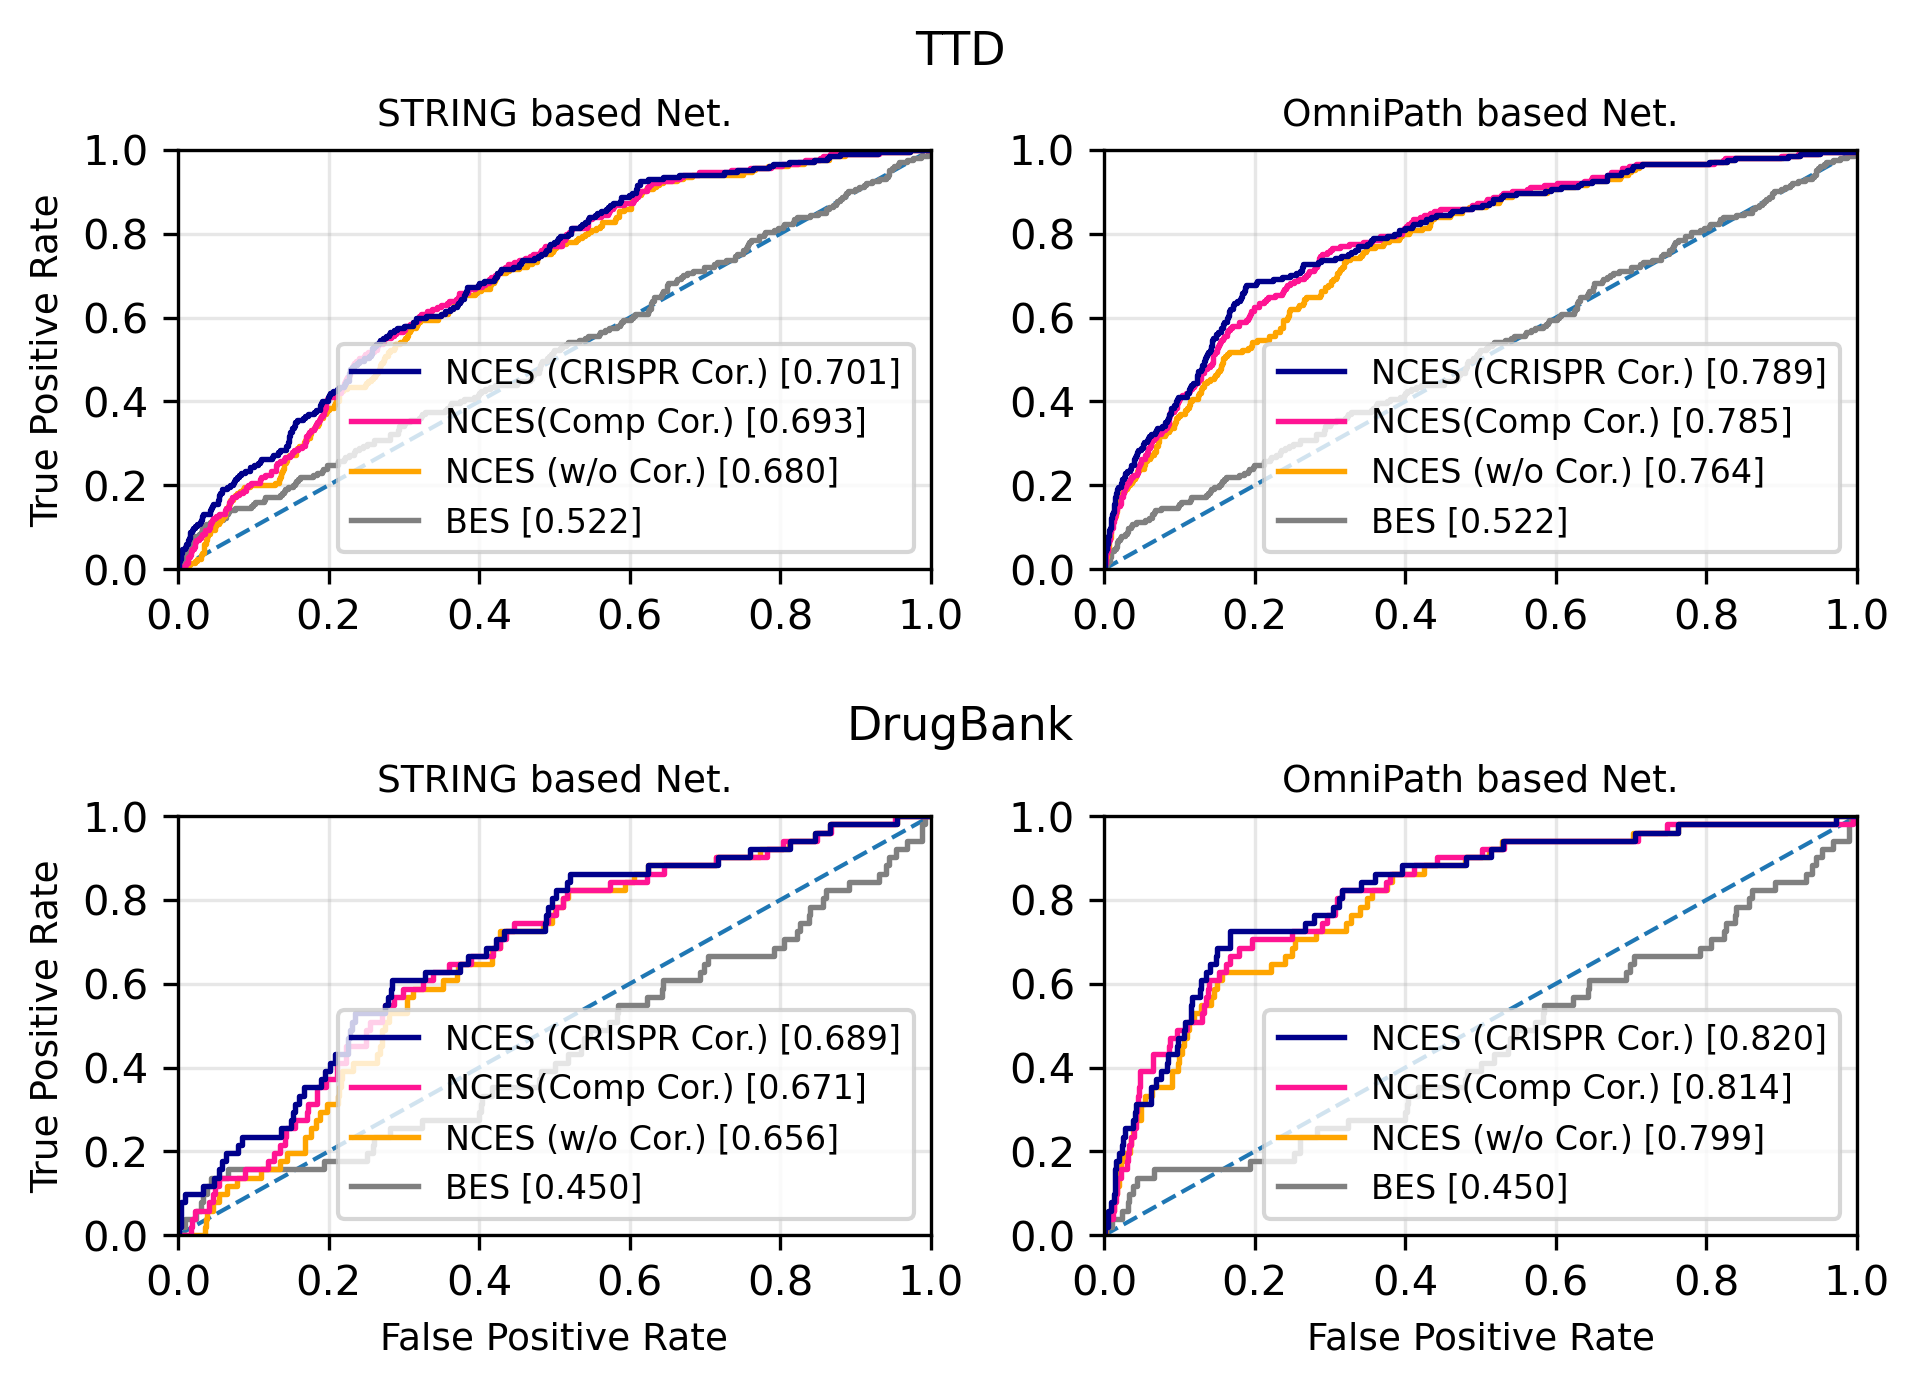

In [456]:
fig=plt.figure(figsize=(6.5,4.5), dpi=300)
axes=fig.subplots(2, 2).flatten()

gs_name={'TTD':'TTD','drugbank':'DrugBank'}

ppi_name={'omnipath_all_ppi':'OmniPath based Net.',
          'string_ppi':'STRING based Net.'}


colors = ['gray', 'orange', 'deeppink', 'darkblue']

with open("./results/two_ppi_agg_p_ess_score.pickle", 'rb') as file:
    ess_score_df=pickle.load(file)
    
cell='A375'
cell_df=ess_score_df[cell]

score_name_dic={}

def get_model_name(score):
    if 'chemical|no_cor' in score:
        return 'NCES (w/o Cor.)'
    if 'crispr|exp_abs(cor)' in score:
        return 'NCES (CRISPR Cor.)'
    if 'chemical|exp_abs(cor)' in score:
        return 'NCES(Comp Cor.)'
    if 'BES' in score:
        return 'BES'

ii=0
for gs in ['TTD', 'drugbank']:
    for ppi in ['string_ppi','omnipath_all_ppi']:
        regex = rf"^{ppi}\|max\|(crispr|chemical)\|(exp_abs\(cor\)|no_cor)\|0\.8$"
        cols_ori = cell_df.filter(regex=regex).columns
        score_cols=['BES']+[col for col in cols_ori if 'crispr|no_cor' not in col]

        ax=axes[ii]
        ii+=1
        _=ax.plot([0, 1], [0, 1], linestyle='--', linewidth=1)
    
        auc_records = []  # (score, auc_val, fpr, tpr) 
    
        for score in score_cols:
            y_true  = cell_df[gs].astype(int).values
            y_score = cell_df[score].astype(float).values
    
            fpr, tpr, _ = roc_curve(y_true, y_score)
            auc_val = roc_auc_score(y_true, y_score)
    
            auc_records.append((score, auc_val, fpr, tpr))
    
        # sort by AUC 
        auc_records.sort(key=lambda x: x[1])
    
        # plot
        for i, (score, auc_val, fpr, tpr) in enumerate(auc_records):
            color = colors[i]
            _=ax.plot(fpr, tpr, linewidth=1.3, color=color, label=f"{get_model_name(score)} [{auc_val:.3f}]")
       
        _=ax.set_title(ppi_name[ppi], fontsize=9)
        _=ax.set_xlabel("False Positive Rate", fontsize=9)
        _=ax.set_ylabel("True Positive Rate", fontsize=9)

        if ii<=2:
            _=ax.set_xlabel("")
            
        if ii%2==0:
            _=ax.set_ylabel("")
            
        _=ax.set_xlim(0, 1)
        _=ax.set_ylim(0, 1)
        _=ax.grid(alpha=0.3)

        handles, labels = ax.get_legend_handles_labels()
        _=ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,0), loc='lower right', fontsize=8)

    fig.text(0.5,1/(ii/2),gs_name[gs], size=11, ha='center', va='center')
#fig.suptitle(cell, fontsize=15)
fig.tight_layout(h_pad=3)
fig.savefig(f'figures/fig_roc_curve_{cell}.png', bbox_inches='tight', dpi=300)

# AUROC values computed across all combination (Table S4)

In [555]:
with open("./results/two_ppi_agg_p_eval_res.pickle", 'rb') as file:
    auroc_res_ori=pickle.load(file)
tmp_df=auroc_res_ori['score_sys'].str.split('|', expand=True)
tmp_df.columns=['net','agg_method','exp_type','corr_weight_method','agg_p']

auroc_res_ori=pd.concat([auroc_res_ori.drop(columns='score_sys'), tmp_df], axis=1)

## BES
auroc_BES=auroc_res_ori.loc[auroc_res_ori['net']=='BES']

auroc_BES = auroc_BES.copy()
auroc_BES['model']=auroc_BES['net']
auroc_BES=auroc_BES[['cell','gs','roc_auc','net','agg_p','model']]#<-net, agg-p not available
auroc_BES['net']='NaN'
auroc_BES['agg_p']='NaN'

## NCES
auroc_res=auroc_res_ori.loc[(auroc_res_ori['agg_method']=='max')&(auroc_res_ori['agg_p']!='1')]
auroc_res=auroc_res.loc[((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='no_cor'))|
                        ((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='exp_abs(cor)'))|
                        ((auroc_res['exp_type']=='crispr')  &(auroc_res['corr_weight_method']=='exp_abs(cor)'))]

auroc_res['model']=auroc_res['exp_type']+'|'+auroc_res['corr_weight_method']
auroc_res=auroc_res[['cell','gs','roc_auc','net','agg_p','model']]

auroc_final=pd.concat([auroc_res,auroc_BES], axis=0)

auroc_final['net']=auroc_final['net'].replace({'omnipath_all_ppi':'OmniPath',
                                               'string_ppi':'STRING'})


nces_no_cor='NCES (w/o Cor.)'
nces_cp_cor='NCES (Comp Cor.)'
nces_c9_cor='NCES (CRISPR Cor.)'

auroc_final['model']=auroc_final['model'].replace({'chemical|no_cor':nces_no_cor,
                                                   'chemical|exp_abs(cor)':nces_cp_cor,
                                                   'crispr|exp_abs(cor)': nces_c9_cor})

auroc_final['model'] = pd.Categorical(auroc_final['model'], categories=['BES',
                                                                        nces_no_cor,
                                                                        nces_cp_cor,
                                                                        nces_c9_cor], ordered=True)

auroc_final=auroc_final[['gs', 'cell', 'model', 'net', 'agg_p', 'roc_auc']].copy()
auroc_final=auroc_final.sort_values(by=['cell', 'gs', 'net', 'agg_p','model'])
auroc_final=auroc_final.rename(columns={'gs':'GS', 'cell': 'Cell', 'net': 'PPI net', 'agg_p': 'p', 'model': 'Scoring scheme', 'roc_auc':'AUROC'})
auroc_final=auroc_final.reset_index(drop=True)
auroc_final
auroc_final.to_csv('results/AUROC_all_combination.csv', sep=',')

,GS,Cell,Scoring scheme,PPI net,p,AUROC
0,TTD,A375,BES,NaN,NaN,0.521715
1,TTD,A375,NCES (w/o Cor.),OmniPath,0.2,0.686603
2,TTD,A375,NCES (Comp Cor.),OmniPath,0.2,0.709039
3,TTD,A375,NCES (CRISPR Cor.),OmniPath,0.2,0.704095
4,TTD,A375,NCES (w/o Cor.),OmniPath,0.4,0.728678
...,...,...,...,...,...,...
345,drugbank,U251MG,NCES (Comp Cor.),STRING,0.6,0.750027
346,drugbank,U251MG,NCES (CRISPR Cor.),STRING,0.6,0.755730
347,drugbank,U251MG,NCES (w/o Cor.),STRING,0.8,0.746566
348,drugbank,U251MG,NCES (Comp Cor.),STRING,0.8,0.752296


# AUROC values line plot (Figure 5)

array(['chemical|exp_abs(cor)', 'chemical|no_cor', 'crispr|exp_abs(cor)',
       'BES'], dtype=object)

Text(0.5, 1.0, 'TTD')

Text(0.5, 0.5, 'DrugBank')

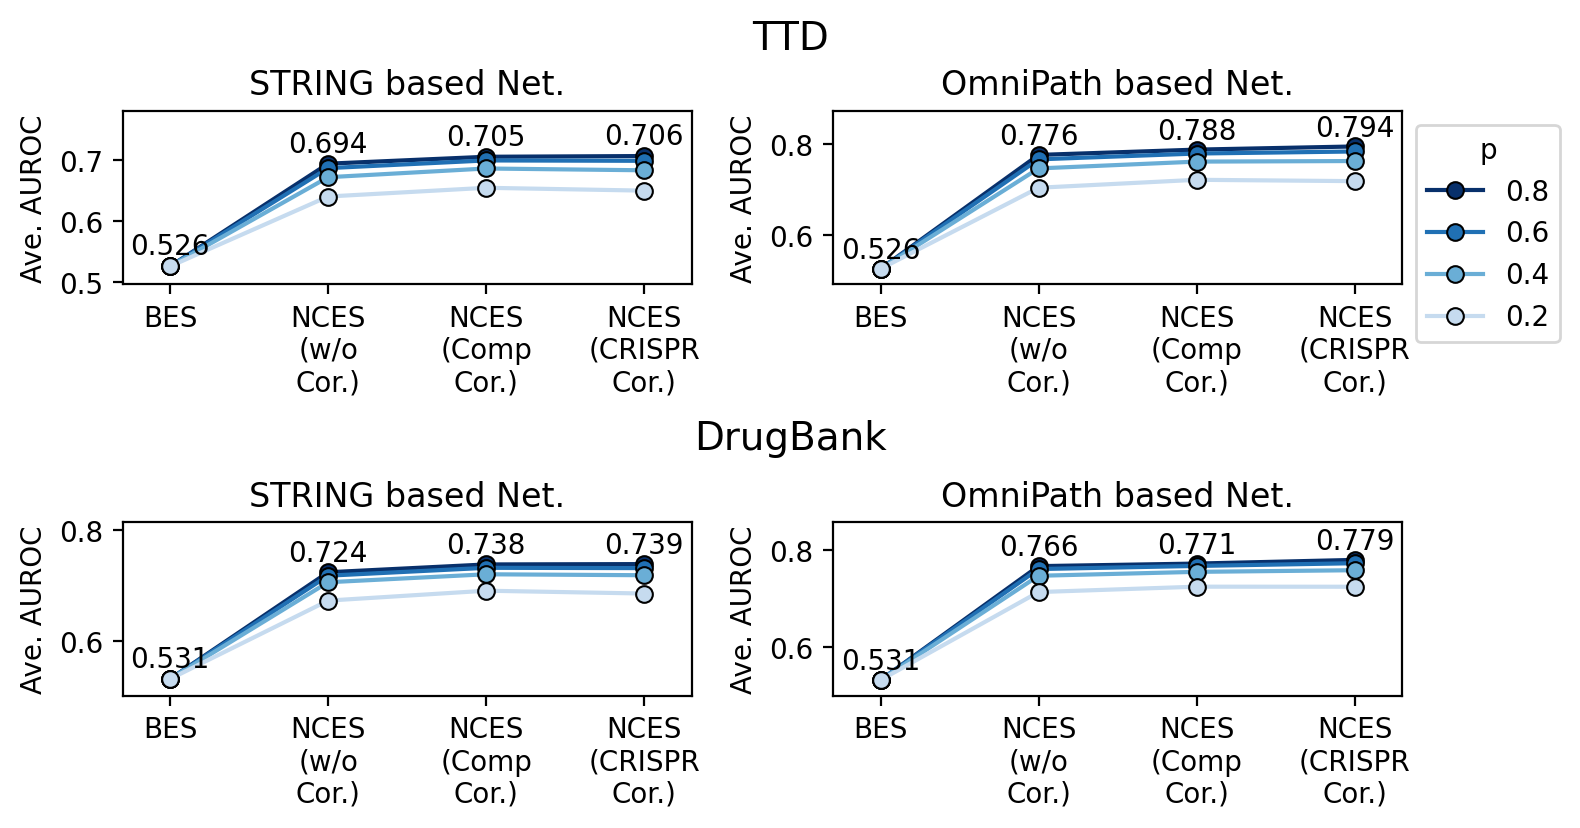

In [437]:
with open("./results/two_ppi_agg_p_eval_res.pickle", 'rb') as file:
    auroc_res_ori=pickle.load(file)
tmp_df=auroc_res_ori['score_sys'].str.split('|', expand=True)
tmp_df.columns=['net','agg_method','exp_type','corr_weight_method','agg_p']

auroc_res_ori=pd.concat([auroc_res_ori.drop(columns='score_sys'), tmp_df], axis=1)

## BES
auroc_BES=auroc_res_ori.loc[auroc_res_ori['net']=='BES']

auroc_BES = auroc_BES.copy()
auroc_BES['model']=auroc_BES['net']
auroc_BES = pd.concat([auroc_BES.assign(net='omnipath_all_ppi'),
                       auroc_BES.assign(net='string_ppi')], ignore_index=True)

auroc_BES = pd.concat([auroc_BES.assign(agg_p='0.2'),
                       auroc_BES.assign(agg_p='0.4'),
                       auroc_BES.assign(agg_p='0.6'),
                       auroc_BES.assign(agg_p='0.8')], ignore_index=True)[['cell','gs','roc_auc','net','agg_p','model']]


## NCES
auroc_res=auroc_res_ori.loc[(auroc_res_ori['agg_method']=='max')&(auroc_res_ori['agg_p']!='1')]
auroc_res=auroc_res.loc[((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='no_cor'))|
                        ((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='exp_abs(cor)'))|
                        ((auroc_res['exp_type']=='crispr')  &(auroc_res['corr_weight_method']=='exp_abs(cor)'))]

auroc_res['model']=auroc_res['exp_type']+'|'+auroc_res['corr_weight_method']
auroc_res=auroc_res[['cell','gs','roc_auc','net','agg_p','model']]
auroc_final=pd.concat([auroc_res,auroc_BES], axis=0)
auroc_final['net']=auroc_final['net'].replace({'omnipath_all_ppi':'OmniPath',
                                               'string_ppi':'STRING'})

auroc_final['model'].unique()

nces_no_cor='NCES\n(w/o\nCor.)'
nces_cp_cor='NCES\n(Comp\nCor.)'
nces_c9_cor='NCES\n(CRISPR\nCor.)'

auroc_final['model']=auroc_final['model'].replace({'chemical|no_cor':nces_no_cor,
                                                   'chemical|exp_abs(cor)':nces_cp_cor,
                                                   'crispr|exp_abs(cor)': nces_c9_cor})

auroc_final['model'] = pd.Categorical(auroc_final['model'], categories=['BES',
                                                                        nces_no_cor,
                                                                        nces_cp_cor,
                                                                        nces_c9_cor], ordered=True)

auroc_final=auroc_final.copy()
auroc_final['gs']=auroc_final['gs'].replace({'drugbank':'DrugBank'})

cmap = plt.get_cmap('Blues')
colors = [cmap(v) for v in [1.0, 0.75, 0.5, 0.25]]

fig=plt.figure(figsize=(8,4), dpi=200)
axs=fig.subplots(2,2).flatten()

ii=0
ytick_margin=0.03
for gs in ['TTD', 'DrugBank']:
    auroc_final_gs=auroc_final.loc[auroc_final['gs']==gs]
    for net in ['STRING','OmniPath']:
        auroc_final_net = auroc_final_gs.loc[auroc_final_gs['net']==net]
        _=sns.lineplot(data=auroc_final_net, y='roc_auc', x='model', hue='agg_p', errorbar=None, ax=axs[ii], hue_order=['0.8','0.6','0.4','0.2'],
                     marker='o', palette=colors, markeredgecolor="black",)
        _=axs[ii].set_ylim(np.array(axs[ii].get_ylim())+np.array([-0.02,0.065]))
        _=axs[ii].set_xlim(-0.3,3.3)
        _=axs[ii].set_title(f'{net} based Net.')
        _=axs[ii].set_ylabel('Ave. AUROC', fontsize=10)
        _=axs[ii].set_xlabel('')
        if ii==1:
            _=axs[ii].legend(bbox_to_anchor=(1,1), loc='upper left', title='p')
        else:
            _=axs[ii].legend().remove()

        ## add text
        auroc_final_p08=auroc_final_net.loc[auroc_final_net['agg_p']=='0.8']
        mean_df=auroc_final_p08.groupby(['model'], observed=True)['roc_auc'].mean().reset_index()
        mean_df['model']=mean_df['model'].cat.rename_categories({'BES':0, nces_no_cor:1, nces_cp_cor:2, nces_c9_cor:3})

        for x,y in zip(mean_df['model'], mean_df['roc_auc']):
            _=axs[ii].text(x,y+0.01,f'{y:.3f}', ha='center', va='bottom')
        
        ii+=1
    fig.text(0.5,1/(ii/2),gs, size=14, ha='center', va='center')
fig.tight_layout(h_pad=3)
fig.savefig('figures/fig_1_auroc_summary.png', bbox_inches='tight', dpi=300)

# statistical significance between scoring schemes (Figure 6)

array(['chemical|exp_abs(cor)', 'chemical|no_cor', 'crispr|exp_abs(cor)',
       'BES'], dtype=object)

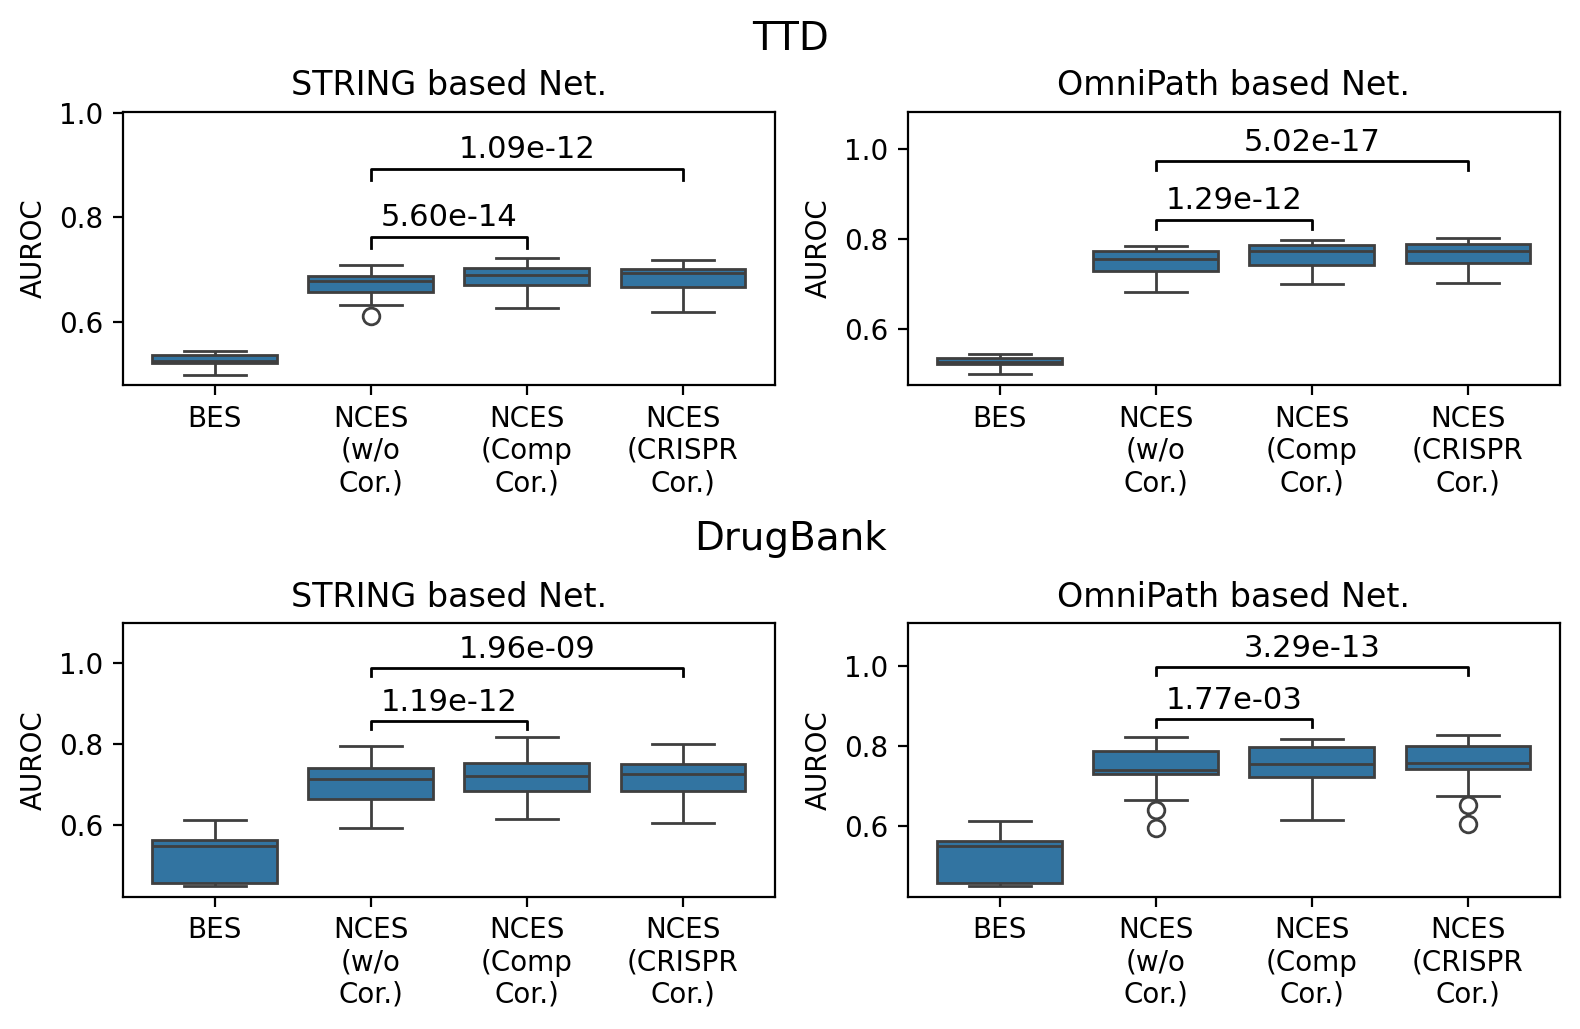

In [640]:
with open("./results/two_ppi_agg_p_eval_res.pickle", 'rb') as file:
    auroc_res_ori=pickle.load(file)
tmp_df=auroc_res_ori['score_sys'].str.split('|', expand=True)
tmp_df.columns=['net','agg_method','exp_type','corr_weight_method','agg_p']

auroc_res_ori=pd.concat([auroc_res_ori.drop(columns='score_sys'), tmp_df], axis=1)

## BES
auroc_BES=auroc_res_ori.loc[auroc_res_ori['net']=='BES']

auroc_BES = auroc_BES.copy()
auroc_BES['model']=auroc_BES['net']
auroc_BES = pd.concat([auroc_BES.assign(net='omnipath_all_ppi'),
                       auroc_BES.assign(net='string_ppi')], ignore_index=True)

auroc_BES = pd.concat([auroc_BES.assign(agg_p='0.2'),
                       auroc_BES.assign(agg_p='0.4'),
                       auroc_BES.assign(agg_p='0.6'),
                       auroc_BES.assign(agg_p='0.8')], ignore_index=True)[['cell','gs','roc_auc','net','agg_p','model']]


## NCES
auroc_res=auroc_res_ori.loc[(auroc_res_ori['agg_method']=='max')&(auroc_res_ori['agg_p']!='1')]
auroc_res=auroc_res.loc[((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='no_cor'))|
                        ((auroc_res['exp_type']=='chemical')&(auroc_res['corr_weight_method']=='exp_abs(cor)'))|
                        ((auroc_res['exp_type']=='crispr')  &(auroc_res['corr_weight_method']=='exp_abs(cor)'))]

auroc_res['model']=auroc_res['exp_type']+'|'+auroc_res['corr_weight_method']
auroc_res=auroc_res[['cell','gs','roc_auc','net','agg_p','model']]
auroc_final=pd.concat([auroc_res,auroc_BES], axis=0)
auroc_final['net']=auroc_final['net'].replace({'omnipath_all_ppi':'OmniPath',
                                               'string_ppi':'STRING'})

auroc_final['model'].unique()

nces_no_cor='NCES\n(w/o\nCor.)'
nces_cp_cor='NCES\n(Comp\nCor.)'
nces_c9_cor='NCES\n(CRISPR\nCor.)'
            
auroc_final['model']=auroc_final['model'].replace({'chemical|no_cor':nces_no_cor,
                                                   'chemical|exp_abs(cor)':nces_cp_cor,
                                                   'crispr|exp_abs(cor)': nces_c9_cor})

auroc_final['model'] = pd.Categorical(auroc_final['model'], categories=['BES',
                                                                        nces_no_cor,
                                                                        nces_cp_cor,
                                                                        nces_c9_cor], ordered=True)

auroc_final=auroc_final.copy()
auroc_final['gs']=auroc_final['gs'].replace({'drugbank':'DrugBank'})

cmap = plt.get_cmap('Blues')
colors = [cmap(v) for v in [1.0, 0.75, 0.5, 0.25]]

fig=plt.figure(figsize=(8,5), dpi=200)
axs=fig.subplots(2,2).flatten()

jj=0
ytick_margin=0.03
for gs in ['TTD', 'DrugBank']:
    auroc_final_gs=auroc_final.loc[auroc_final['gs']==gs]
    for net in ['STRING','OmniPath']:
        auroc_final_net = auroc_final_gs.loc[auroc_final_gs['net']==net]
        base_model=auroc_final_net.loc[auroc_final_net['model']==nces_no_cor][['cell','agg_p','roc_auc']]
        model_pval={}
        for model1 in [nces_cp_cor,nces_c9_cor]:
            case_model=auroc_final_net.loc[auroc_final_net['model']==model1][['cell','agg_p','roc_auc']]
            merged_df=pd.merge(base_model, case_model, on=['cell','agg_p'], suffixes=['_no_cor', '_with_cor'])# <======= net 추가

            stat, p_value = stats.ttest_rel(merged_df['roc_auc_with_cor'], merged_df['roc_auc_no_cor'], alternative='greater')
            #stat, p_value = stats.wilcoxon(merged_df['roc_auc_with_cor'], merged_df['roc_auc_no_cor'], alternative='greater')
            model_pval[model1]=p_value

        ax=axs[jj]
        jj+=1
        _=sns.boxplot(data=auroc_final_net, y='roc_auc', x='model', ax=ax)
        _=ax.set_ylabel('AUROC', fontsize=11)
        
        
        # ---- annotation ----
        def add_sig(ax, x1, x2, y, h, label):
            """박스플롯 위에 통계 결과 annotation"""
            _=ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='k')
            _=ax.text((x1+x2)*0.5, y+0.03, label, ha='center', va='bottom', fontsize=11)
        
        # set y range by max roc_auc
        ymax = auroc_final_net['roc_auc'].max()
        h = 0.02  # 박스와 annotation 간격

        labels = [tick.get_text() for tick in ax.get_xticklabels()]

        _=add_sig(ax, 1, 2, ymax+0.02, h, f'{model_pval[labels[2]]:.2e}')
        
        _=add_sig(ax, 1, 3, ymax+0.15, h, f'{model_pval[labels[3]]:.2e}')
        
        _=ax.set_ylim(ax.get_ylim()[0], ymax+0.28)

        _=ax.set_title(f'{net} based Net.')
        _=ax.set_ylabel('AUROC', fontsize=10)
        _=ax.set_xlabel('')

    _=fig.text(0.5,1/(jj/2),gs, size=14, ha='center', va='center')
fig.tight_layout(h_pad=3)
fig.savefig('figures/auroc_diff_sig_among_score_schemes.png', bbox_inches='tight', dpi=300)